In [1]:
using PyPlot, JLD, AnomalyDetection, EvalCurves
import PyPlot: plot
include("./plots.jl")

PyPlot.plot

In [2]:
# load data
dataset = load("toy_data_3.jld")["data"]
X = AnomalyDetection.Float.(dataset.data)
Y = dataset.labels
nX = X[:, Y.==0]

2×90 Array{Float32,2}:
 0.803442  0.804605  0.807145  0.819485  …  0.0350314  0.0613807  0.0685027
 0.821998  0.834235  0.826129  0.848182     0.973926   1.00745    0.973256 

In [78]:
# VAE settings
indim = size(X,1)
hiddendim = 10
latentdim = 2
nlayers = 2

# setup the VAE object
variant = :sigma
    # :unit - output has unit variance
    # :sigma - the variance of the output is estimated
esize = [indim; hiddendim; hiddendim; latentdim*2] # encoder architecture
# decoder architecture
(variant == :unit)? dsize = [latentdim; hiddendim; hiddendim; indim] :
    dsize = [latentdim; hiddendim; hiddendim; 2*indim]
lambda = 1 # KLD weight in loss function
threshold = 0 # classification threshold, is recomputed using setthreshold!()
contamination = size(Y[Y.==1],1)/size(Y, 1) # for automatic threshold computation
iterations = 2000
cbit = 500 # after this number of iteratiosn, callback is printed
verbfit = true
M = 1 # reconstruction error samples, for training 1 is OK
L = 50 # batchsize 
# set low for training but high for classification
activation = Flux.relu
layer = Flux.Dense
rdelta = Inf # reconstruction error threshold for training stopping
Beta = 1.0 # for automatic threshold computation, in [0, 1] 
# 1.0 = tight around normal samples
tracked = true # do you want to store training progress?
# it can be later retrieved from model.traindata
model = VAEmodel(esize, dsize, lambda, threshold, contamination, iterations, cbit, verbfit, 
    L, M=M, activation = activation, layer = layer, rdelta = rdelta, Beta = Beta, 
    tracked = tracked, variant = variant)

AnomalyDetection.VAEmodel(AnomalyDetection.VAE{Flux.Chain,AnomalyDetection.#sample_z,Flux.Chain,Val{:sigma}}(Chain(Dense(2, 10, NNlib.relu), Dense(10, 10, NNlib.relu), Dense(10, 4)), AnomalyDetection.sample_z, Chain(Dense(2, 10, NNlib.relu), Dense(10, 10, NNlib.relu), Dense(10, 4)), Val{:sigma}()), 1, 0, 0.1262135922330097, 2000, 500, true, 50, 1, Inf32, 1.0f0, MVHistory{ValueHistories.History}, "likelihood")

In [79]:
# fit the model
AnomalyDetection.evalloss(model, nX)
@time AnomalyDetection.fit!(model, nX)
AnomalyDetection.evalloss(model, nX)
AnomalyDetection.setthreshold!(model, X)

loss: 0.50490457
likelihood: 0.38992572
KL: 0.09817062

loss: -1.8513933
likelihood: -2.0419564
KL: 0.06319007

loss: -2.2449994
likelihood: -3.3513787
KL: 0.91800356

loss: -2.3194041
likelihood: -4.419359
KL: 1.3478897

loss: -3.3442495
likelihood: -5.399656
KL: 1.8305943

  3.624359 seconds (11.12 M allocations: 1.628 GiB, 6.92% gc time)
loss: -3.94001
likelihood: -5.5344515
KL: 1.787674



0.98209524f0

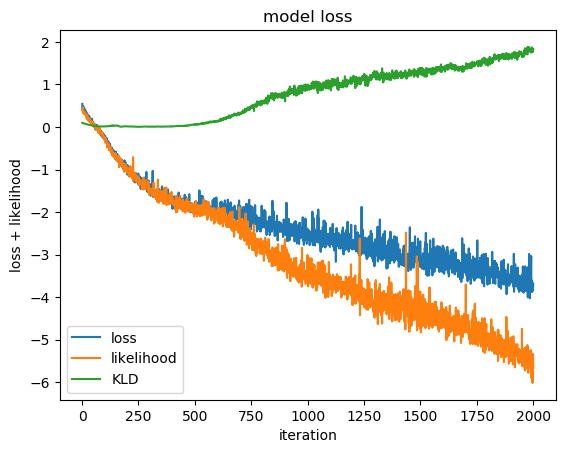

In [80]:
plot(model)
show()

How does the model reconstruct the normal data?

In [81]:
model(nX)

Tracked 4×90 Array{Float32,2}:
  0.825731   0.7825     0.692537  …   0.0301045   0.068579   0.052949
  0.807147   0.790613   0.72865       0.996975    0.995688   1.00574 
 -6.57531   -6.16031   -5.57513      -7.39649    -6.47916   -6.89828 
 -6.54037   -6.13149   -5.56195      -7.99785    -7.02018   -7.43522 

In [82]:
nX

2×90 Array{Float32,2}:
 0.803442  0.804605  0.807145  0.819485  …  0.0350314  0.0613807  0.0685027
 0.821998  0.834235  0.826129  0.848182     0.973926   1.00745    0.973256 

What are the parameters of $q(z|x)$?

In [83]:
AnomalyDetection.muz(model, nX)

Tracked 2×90 Array{Float32,2}:
 0.113519  0.115871  0.114675  …  -0.0229866  -0.0130196  -0.0157492
 1.27962   1.28559   1.29499      -1.23231    -1.15624    -1.13502  

In [84]:
AnomalyDetection.sigma2z(model, nX)

Tracked 2×90 Array{Float32,2}:
 0.920244   0.921557   0.921391   …  0.861312   0.866245   0.863177 
 0.0300336  0.0294827  0.0298525     0.0286772  0.0267841  0.0282666

What do the generated samples look like?

In [85]:
AnomalyDetection.sample_z(model, nX)

Tracked 2×90 Array{Float32,2}:
 0.0732163  0.880582  0.0856243  1.11534  …  -0.668409   1.67523  -1.19803
 1.54479    1.23623   1.20676    1.26666     -0.908476  -1.15602  -1.16898

In [86]:
# predict labels on testing data
model.M = 100 # for classification higher is better (more stable)
tryhat = AnomalyDetection.predict(model, X)

103-element Array{Int64,1}:
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 ⋮
 1
 1
 1
 1
 1
 1
 1
 0
 1
 1
 0
 1

In [87]:
# get the labels and roc stats
tryhat, tstyhat = AnomalyDetection.rocstats(dataset, dataset, model);


 Training data performance: 
MLBase.ROCNums{Int64}
  p = 13
  n = 90
  tp = 11
  tn = 88
  fp = 2
  fn = 2
precision: 0.8461538461538461
f1score: 0.8461538461538461
recall: 0.8461538461538461
false positive rate: 0.022222222222222223
equal error rate: 0.08803418803418804

 Testing data performance: 
MLBase.ROCNums{Int64}
  p = 13
  n = 90
  tp = 13
  tn = 89
  fp = 1
  fn = 0
precision: 0.9285714285714286
f1score: 0.9629629629629629
recall: 1.0
false positive rate: 0.011111111111111112
equal error rate: 0.005555555555555556


In [88]:
# anomaly score contour plot
# get limits of the figure
xl = (minimum(X[1,:])-0.05, maximum(X[1,:]) + 0.05)
yl = (minimum(X[2,:])-0.05, maximum(X[2,:]) + 0.05)

# compute the anomaly score on a grid
x = linspace(xl[1], xl[2], 30)
y = linspace(yl[1], yl[2], 30)
zz = zeros(size(y,1),size(x,1))
for i in 1:size(y, 1)
    for j in 1:size(x, 1)
        zz[i,j] = AnomalyDetection.anomalyscore(model, AnomalyDetection.Float.([x[j], y[i]]))
    end
end

# also generate some samples
xgen = AnomalyDetection.generate(model, 3);

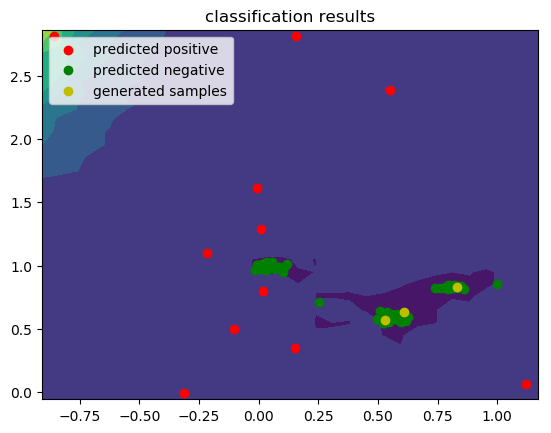

In [89]:
# plot it all
f = figure()
contourf(x, y, zz)
scatter(X[1, tryhat.==1], X[2, tryhat.==1], c = "r", 
    label = "predicted positive")
scatter(X[1, tryhat.==0], X[2, tryhat.==0], c = "g", 
    label = "predicted negative")
scatter(xgen[1,:], xgen[2, :], c = "y", 
    label = "generated samples")
title("classification results")
xlim(xl)
ylim(yl)
legend()
show()

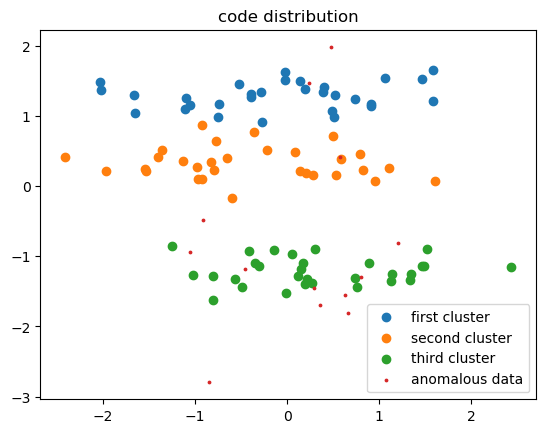

In [90]:
# what are the codes?
z1 = AnomalyDetection.getcode(model, X[:,1:30]).data
z2 = AnomalyDetection.getcode(model, X[:,31:60]).data
z3 = AnomalyDetection.getcode(model, X[:,61:90]).data
za = AnomalyDetection.getcode(model, X[:,91:end]).data

figure()
title("code distribution")
scatter(z1[1,:], z1[2,:], label = "first cluster")
scatter(z2[1,:], z2[2,:], label = "second cluster")
scatter(z3[1,:], z3[2,:], label = "third cluster")
scatter(za[1,:], za[2,:], s = 3, label = "anomalous data")
legend()
show()

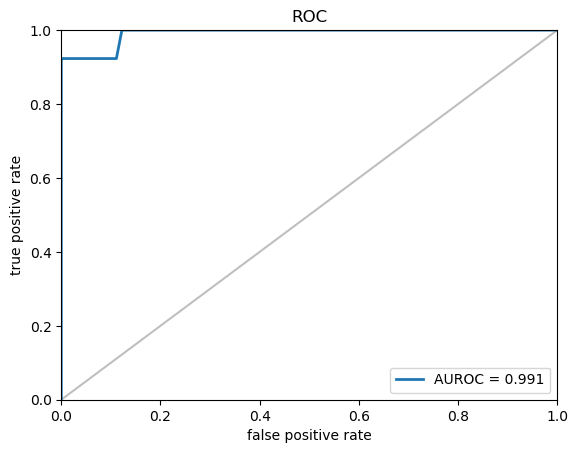

In [91]:
# plot ROC curve and compute AUROC score
ascore = AnomalyDetection.anomalyscore(model, X);
fprvec, tprvec = EvalCurves.roccurve(ascore, Y)
auroc = round(EvalCurves.auc(fprvec, tprvec),3)
EvalCurves.plotroc((fprvec, tprvec, "AUROC = $(auroc)"))
show()